# 🧪 EDA inicial — Crypto (CoinGecko)

Este notebook está pensado como **plantilla mínima** para empezar tu análisis exploratorio con los **datos crudos** exportados por `scripts/export_raw.py`.

> *Tip:* Primero ejecutá: `python scripts/export_raw.py` para generar `./data/<coin>_raw.csv` o `./data/<coin>_raw.json`.


In [9]:
import os
os.chdir(r"c:\Users\usuario\Desktop\Proyecto DS\crypto-pipeline-coingecko")
print("Nuevo CWD:", os.getcwd())

Nuevo CWD: c:\Users\usuario\Desktop\Proyecto DS\crypto-pipeline-coingecko


In [11]:
# --- Configuración básica ---
# Elegí la moneda (debe coincidir con el coin_id exportado)
COIN = "bitcoin"   # ejemplo: "bitcoin", "ethereum", "solana"

CSV_PATH = f"./data/{COIN}_raw.csv"
JSON_PATH = f"./data/{COIN}_raw.json"

import pandas as pd
from pathlib import Path

pd.set_option("display.max_rows", 20)
pd.set_option("display.width", 120)

# Intentar cargar CSV, si no existe probar JSON
if Path(CSV_PATH).exists():
    df = pd.read_csv(CSV_PATH)
elif Path(JSON_PATH).exists():
    df = pd.read_json(JSON_PATH)
else:
    raise FileNotFoundError(f"No encuentro {CSV_PATH} ni {JSON_PATH}. Corré primero: python scripts/export_raw.py")

print("✔ Dataset cargado:", COIN, "| Filas:", len(df), "| Columnas:", list(df.columns))
df.head()

✔ Dataset cargado: bitcoin | Filas: 2164 | Columnas: ['coin_id', 'ts_utc', 'price', 'market_cap', 'total_volume']


,coin_id,ts_utc,price,market_cap,total_volume
0,bitcoin,2025-06-03 00:03:46,105883.831757,2.104349e+12,2.636969e+10
1,bitcoin,2025-06-03 01:03:23,106303.264233,2.112742e+12,2.685626e+10
2,bitcoin,2025-06-03 02:03:10,106415.398052,2.114077e+12,2.722596e+10
3,bitcoin,2025-06-03 03:02:40,105912.222356,2.104976e+12,2.764400e+10
4,bitcoin,2025-06-03 04:03:28,105559.570950,2.098234e+12,2.721849e+10


In [12]:
import json

with open("./data/bitcoin_metadata.json", "r", encoding="utf-8") as f:
    btc_meta = json.load(f)

# Ver las claves principales
btc_meta.keys()

dict_keys(['id', 'symbol', 'name', 'web_slug', 'asset_platform_id', 'platforms', 'detail_platforms', 'block_time_in_minutes', 'hashing_algorithm', 'categories', 'preview_listing', 'public_notice', 'additional_notices', 'description', 'links', 'image', 'country_origin', 'genesis_date', 'sentiment_votes_up_percentage', 'sentiment_votes_down_percentage', 'watchlist_portfolio_users', 'market_cap_rank', 'market_data', 'community_data', 'developer_data', 'status_updates', 'last_updated'])

In [14]:
# Nombre y símbolo
print("Nombre:", btc_meta["name"])
print("Símbolo:", btc_meta["symbol"])

# Precio actual en USD
print("Precio USD:", btc_meta["market_data"]["current_price"]["usd"])

# Market Cap
print("Market Cap USD:", btc_meta["market_data"]["market_cap"]["usd"])

# Máximo histórico (ATH) y fecha
print("ATH:", btc_meta["market_data"]["ath"]["usd"])
print("ATH Fecha:", btc_meta["market_data"]["ath_date"]["usd"])

# Comunidad
#print("Twitter followers:", btc_meta["community_data"]["twitter_followers"])

# Repositorio (GitHub)
print("Stars:", btc_meta["developer_data"]["stars"])

Nombre: Bitcoin
Símbolo: btc
Precio USD: 108194
Market Cap USD: 2154312771471
ATH: 124128
ATH Fecha: 2025-08-14T00:37:02.582Z
Stars: 73168


## 1) Limpieza mínima
- Parseo de fecha
- Orden cronológico
- Tipos numéricos


In [15]:
# Convertir timestamp a datetime si viene como string
if "ts_utc" in df.columns:
    df["ts_utc"] = pd.to_datetime(df["ts_utc"], utc=True, errors="coerce")
    df = df.sort_values("ts_utc").reset_index(drop=True)
    df = df.set_index("ts_utc")

# Asegurar numéricos
for col in ["price", "market_cap", "total_volume"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2164 entries, 2025-06-03 00:03:46+00:00 to 2025-09-01 00:14:34+00:00
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   coin_id       2164 non-null   object 
 1   price         2164 non-null   float64
 2   market_cap    2164 non-null   float64
 3   total_volume  2164 non-null   float64
dtypes: float64(3), object(1)
memory usage: 84.5+ KB


## 2) Vistazo rápido

In [17]:
df.describe()


,price,market_cap,total_volume
count,2164.000000,2.164000e+03,2.164000e+03
mean,112164.197437,2.231415e+12,3.713453e+10
std,5563.494667,1.115561e+11,1.533546e+10
min,98974.669555,1.968214e+12,8.163551e+09
25%,107338.320417,2.134262e+12,2.543090e+10
50%,112760.872216,2.244467e+12,3.468331e+10
75%,117703.077253,2.341774e+12,4.647202e+10
max,123782.080087,2.463195e+12,1.482507e+11


## 3) Gráficos básicos
> Streamlit ya te muestra una línea simple, pero acá podés hacer inspecciones libres con matplotlib.


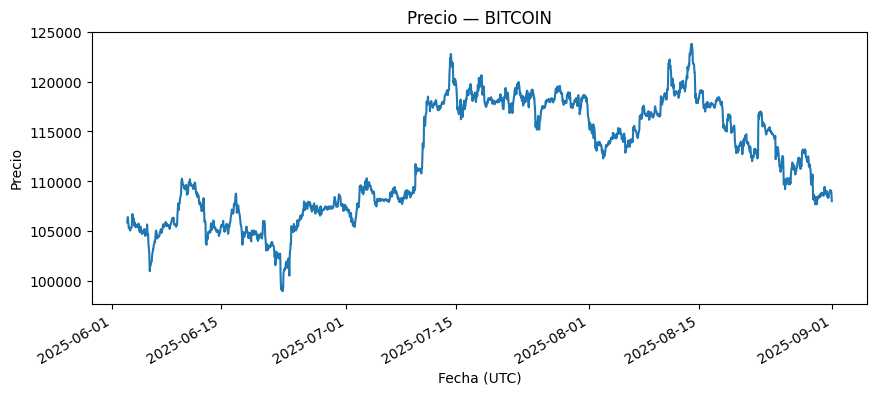

In [18]:
import matplotlib.pyplot as plt

# Precio en el tiempo
ax = df["price"].plot(figsize=(10,4), title=f"Precio — {COIN.upper()}")
ax.set_xlabel("Fecha (UTC)")
ax.set_ylabel("Precio")
plt.show()


In [ ]:
# Histograma simple de precio
ax = df["price"].dropna().plot(kind="hist", bins=30, figsize=(8,4), title=f"Histograma de precio — {COIN.upper()}")
ax.set_xlabel("Precio")
plt.show()


## 4) (Opcional) Primeras features
Estas celdas están **listas pero podés comentarlas** si querés ir de a poco.


In [ ]:
# Retorno porcentual diario (si tus datos son subdiarios, resampleá antes)
# df_d = df.resample("1D").mean()
# df_d["ret"] = df_d["price"].pct_change()
# df_d[["price","ret"]].tail(10)

In [ ]:
# Media móvil simple (7 días) sobre datos diarios
# df_d["ma_7"] = df_d["price"].rolling(7).mean()
# ax = df_d[["price","ma_7"]].plot(figsize=(10,4), title=f"Precio + MA7 — {COIN.upper()}")
# ax.set_xlabel("Fecha (UTC)")
# ax.set_ylabel("Precio")
# plt.show()